In [48]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
tf.keras.backend.clear_session()
from tensorflow import keras
from tensorflow.keras import layers
from os import listdir
from os.path import isfile, join

In [49]:
deph_maps = keras.Input(shape=(32, 360, 3), name='Depht_map')
x = layers.Conv2D(64, 3, activation='relu')(deph_maps)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(93, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(93, 5, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)
deph_maps_output = layers.Flatten(name="Char_vect")(x)

encoder = keras.Model(deph_maps, deph_maps_output, name='encoder')

In [50]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Depht_map (InputLayer)       [(None, 32, 360, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 358, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 179, 64)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 179, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 177, 93)       53661     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 88, 93)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 84, 93)         2163

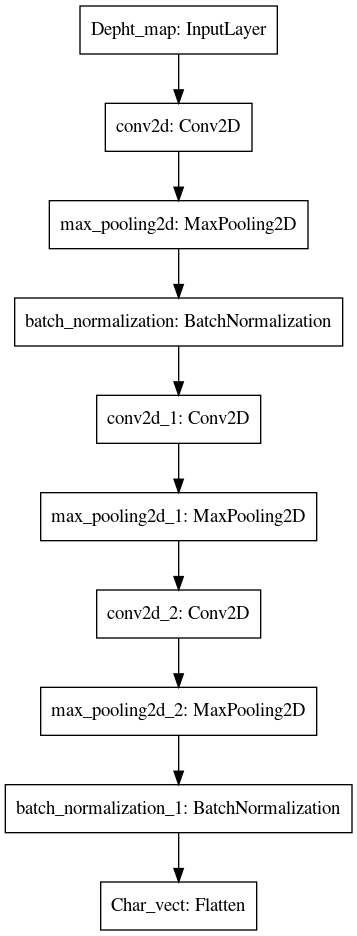

In [51]:
keras.utils.plot_model(encoder, 'Encoder.png')

In [67]:
Courrent_Dm= keras.Input(shape=(32, 360, 3), name='img_i')
Previous_Dm= keras.Input(shape=(32, 360, 3), name='img_in1')
IM=encoder(Courrent_Dm)
IM2=encoder(Previous_Dm)
C=layers.concatenate([IM, IM2])
Y=layers.Dense(100,activation='relu')(C)
Y=layers.Dense(100,activation='relu')(Y)
Yr=layers.Dense(40,activation='relu')(Y)
Yt=layers.Dense(40,activation='relu')(Y)
Yt=layers.Dense(100,activation='relu')(Yt)
Yr=layers.Dense(10,activation='relu')(Yr)
T=layers.Dense(3,name="Traslations")(Yt)
Yr=layers.Dense(4)(Yr)
R=layers.LayerNormalization(axis=1,name="Quaternions")(Yr)

Odometrymodel = keras.Model(inputs=[Courrent_Dm, Previous_Dm],
                    outputs=[T, R])

In [68]:
Odometrymodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_i (InputLayer)              [(None, 32, 360, 3)] 0                                            
__________________________________________________________________________________________________
img_in1 (InputLayer)            [(None, 32, 360, 3)] 0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 3906)         272399      img_i[0][0]                      
                                                                 img_in1[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 7812)         0           encoder[9][0]              

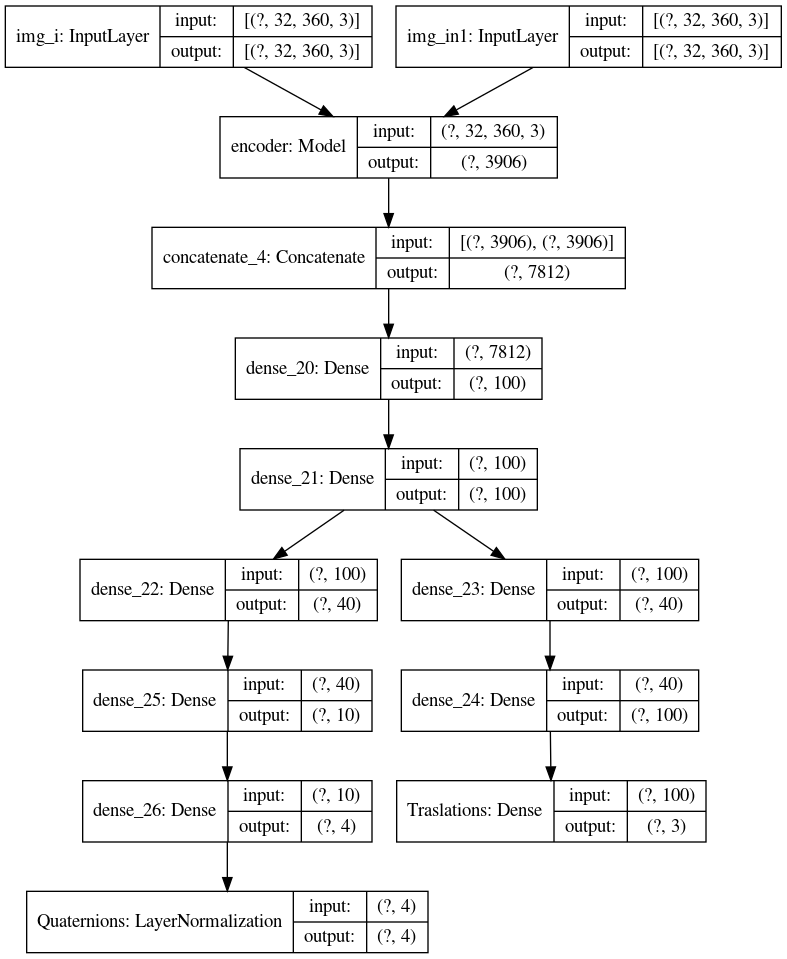

In [69]:
keras.utils.plot_model(Odometrymodel, 'multi_input_and_output_model.png', show_shapes=True)

In [66]:
loss_object =tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()


train_loss1 =tf.keras.metrics.MeanAbsoluteError(name='train_MAE_Traslation')
train_losss1 = tf.keras.metrics.MeanSquaredError(name='train_MSE_Traslation')

test_loss1 = tf.keras.metrics.MeanAbsoluteError(name='test_MAE_Traslation')
test_losss1 = tf.keras.metrics.MeanSquaredError(name='test_MSE_Traslation')

train_loss2 = tf.keras.metrics.MeanAbsoluteError(name='train_MAE_Rotation')
train_losss2 = tf.keras.metrics.MeanSquaredError(name='train_MSE_Traslation')

test_loss2 = tf.keras.metrics.MeanAbsoluteError(name='test_MAE_Rotation')
test_losss2 = tf.keras.metrics.MeanSquaredError(name='test_MSE_Traslation')

In [56]:
@tf.function
def train_step(images, targett, targetr):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions1,predictions2 = Odometrymodel({"img_i":images[1:],"img_in1":images[:-1]}, training=True)
        loss1 = loss_object(targett, predictions1,sample_weight=3)
        loss2 = loss_object(targetr, predictions2,sample_weight=0.5)
    gradients = tape.gradient({"Traslations":loss1,"Quaternions":loss2}, Odometrymodel.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Odometrymodel.trainable_variables))

    train_loss1(targett,predictions1)
    train_losss1(targett,predictions1)
    
    train_loss2(targetr,predictions2)
    train_losss2(targetr,predictions2)

@tf.function
def test_step(images, targett, targetr):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions1,predictions2 = Odometrymodel({"img_i":images[1:],"img_in1":images[:-1]}, training=False)
    t_loss = loss_object(targett, predictions1)
    t_loss2 = loss_object(targetr, predictions2)
    
    test_loss1(targett, predictions1)
    test_losss1(targett, predictions1)
    test_loss2(targetr, predictions2)
    test_losss2(targetr, predictions2)

In [57]:
EPOCHS = 6
batch_size=100
route="/home/david/Documents"
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss1.reset_states()
    train_losss1.reset_states()
    test_loss1.reset_states()
    test_losss1.reset_states()
    train_loss2.reset_states()
    train_losss2.reset_states()
    test_loss2.reset_states()
    test_losss2.reset_states()
    Dm_train=[f for f in listdir(route+"/") if f.startswith("D_train")]
    Dm_train.sort(key=lambda name: int(name[8:-4]))
    Dm_test=[f for f in listdir(route+"/") if f.startswith("D_test")]
    Dm_test.sort(key=lambda name: int(name[7:-4]))
    for file in Dm_train:
        Dic=np.load(file, allow_pickle=True)
        Images=Dic[()]["depth_map"]
        Targett=Dic[()]["Traslations"]
        Targetr=Dic[()]["Rotations"]
        size=Targetr.shape
        for batch in range (int(np.ceil(size[0]/batch_size))):
            Images_b=Images[batch*batch_size:batch*batch_size+batch_size+1]
            #print (Images_b.shape)
            Targett_b=Targett[batch*batch_size:batch*batch_size+batch_size]
            #print(Targett_b.shape)
            Targetr_b=Targetr[batch*batch_size:batch*batch_size+batch_size]
            #print(Targetr_b.shape)
            train_step(Images_b, Targett_b.reshape(-1,1,3),Targetr_b.reshape(-1,1,4))

    for file in Dm_test:
        Dic=np.load(file, allow_pickle=True)
        Images=Dic[()]["depth_map"]
        Targett=Dic[()]["Traslations"]
        Targetr=Dic[()]["Rotations"]
        size=Targetr.shape
        for batch in range (int(np.ceil(size[0]/batch_size))):
            Images_b=Images[batch*batch_size:batch*batch_size+batch_size+1]
            Targett_b=Targett[batch*batch_size:batch*batch_size+batch_size]
            Targetr_b=Targetr[batch*batch_size:batch*batch_size+batch_size]
            test_step(Images_b, Targett_b.reshape(-1,1,3),Targetr_b.reshape(-1,1,4))

    template = 'Epoch :{0:.0f} MAE_T: {1:.4f}, MSE_T: {2:.4f}, Test_MAE_T: {3:.4f}, Test_MSE_T: {4:.4f}' 
    template2= "         MAE_R: {0:.4f}, MSE_R: {1:.4f}, Test_MAE_R: {2:.4f}, Test_MSE_R: {3:.4f}"
    print(template.format(epoch+1,
                        train_loss1.result(),
                        train_losss1.result(),
                        test_loss1.result(),
                        test_losss1.result()))
          
    print(template2.format(train_loss2.result(),
                            train_losss2.result(),
                            test_loss2.result(),
                            test_losss2.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch :1 MAE_T: 0.4110, MSE_T: 0.3718, Test_MAE_T: 0.4209, Test_MSE_T: 0.3298
         MAE_R: 0.4622, MSE_R: 0.2483, Test_MAE_R: 0.3118, Test_MSE_R: 0.0994
Epoch :2 MAE_T: 0.3906, MSE_T: 0.3727, Test_MAE_T: 0.4210, Test_MSE_T: 0.3285
         MAE_R: 0.2083, MSE_R: 0.0513, Test_MAE_R: 0.1225, Test_MSE_R: 0.0176
Epoch :3 MAE_T: 0.3916, MSE_T: 0.3723, Test_MAE_T: 0.4199, Test_MSE_T: 0.3265
         MAE_R: 0.0755, MSE_R: 0.0101, Test_MAE_R: 0.0381, Test_MSE_R: 0.0025
Epoch :4 MAE_T: 0.3919, MSE_T: 0.3707, T

In [58]:
stuff=np.zeros((1,7))
for i in range(1,6):
    Dic=np.load("/home/david/Documents/D_train_{}.npy".format(i), allow_pickle=True)
    Images=Dic[()]["depth_map"]
    Targett=Dic[()]["Traslations"]
    Targetr=Dic[()]["Rotations"]
    predictions1,predictions2 = Odometrymodel({"img_i":Images[1:],"img_in1":Images[:-1]}, training=False)
    fullarray=np.append(predictions1.numpy(),predictions2.numpy(),axis=1)
    stuff=np.append(stuff,fullarray,axis=0)
np.savetxt('test.txt', stuff, delimiter=' ') 

In [59]:
directions=np.loadtxt("test.txt")

In [60]:
directions

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08103526,  0.07408322,  0.00065123, ..., -0.00836891,
        -0.011989  ,  0.01342636],
       [ 0.08103526,  0.07408322,  0.00065123, ..., -0.00699371,
        -0.00419021,  0.0069443 ],
       ...,
       [ 0.08103526,  0.07408322,  0.00065123, ..., -0.02942115,
         0.02230287,  0.00312781],
       [ 0.08103526,  0.07408322,  0.00065123, ..., -0.01689953,
         0.01974988, -0.00337648],
       [ 0.08103526,  0.07408322,  0.00065123, ..., -0.0211224 ,
         0.01995337, -0.00074059]])

In [38]:
predictions2

<tf.Tensor: id=24229, shape=(540, 4), dtype=float32, numpy=
array([[ 9.9352837e-01, -8.6137652e-04,  7.4878335e-04,  8.7407231e-04],
       [ 9.9352837e-01, -8.6137652e-04,  7.4878335e-04,  8.7407231e-04],
       [ 9.9352837e-01, -8.6137652e-04,  7.4878335e-04,  8.7407231e-04],
       ...,
       [ 9.9352837e-01, -8.6137652e-04,  7.4878335e-04,  8.7407231e-04],
       [ 9.9352837e-01, -8.6137652e-04,  7.4878335e-04,  8.7407231e-04],
       [ 9.9352837e-01, -8.6137652e-04,  7.4878335e-04,  8.7407231e-04]],
      dtype=float32)>

In [15]:
Targetr

array([[ 9.99999101e-01, -2.94847395e-04,  2.84773145e-04,
         1.27678571e-03],
       [ 9.99997737e-01,  5.89592027e-04, -1.28592540e-03,
         1.58897050e-03],
       [ 9.99998609e-01,  1.15616668e-03, -4.89402025e-04,
         1.09808506e-03],
       ...,
       [ 9.99998104e-01,  1.25462547e-03,  1.48742440e-03,
        -7.96700348e-05],
       [ 9.99997171e-01,  1.89127215e-03,  1.42637657e-03,
        -2.15102836e-04],
       [ 9.99997917e-01,  1.78362558e-03,  8.34209318e-04,
        -5.37343332e-04]])